# Using Linear Regression to Predict Housing Prices,  by Samson Haile

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go


In [2]:
df = pd.read_csv('../project/kc_house_data.csv')
df.tail(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21603,7852140040,20140825T000000,507250.0,3,2.50,2270,5536,2.0,0,0,...,8,2270,0,2003,0,98065,47.5389,-121.881,2270,5731
21604,9834201367,20150126T000000,429000.0,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21605,3448900210,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
21606,7936000429,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
21607,2997800021,20150219T000000,475000.0,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


# Data Exploration and Descriptive Statistics

#### The dataset contains 21,613 properties in King County, WA, that were sold between May 2014 and May 2015. Each house in the dataset has 21 variables that vary from build quality to sale price.

In [3]:
print(len(df))
print(df.columns)

21613
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


* Cleaning up data: 
    * I'm going to delete the id and date column, since I don't need them for the project.
    * One potential problem I noticed is that over half the properties don't have a basement. This could be an issue since the living area sqft is calculated by sqft_above + sqft_basement, so it may cause outliers.
    * I won't delete the basement column since it would take away from other houses
        * I will create a new dataframe that only uses the above ground sqft (sqft_above), and compare if this makes a difference

In [4]:
print(len(df[df['sqft_basement'] == 0])) # Over half the properties have no basement

13126


In [5]:
df = df.drop(['id', 'date'],1)
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### Now that the data is imported, let's take a look at some descriptive statistics for each variable.

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # getting rid of scientific notations

In [7]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,3.409,7.657,1788.391,291.509,1971.005,84.402,98077.940,47.560,-122.214,1986.552,12768.456
std,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,0.651,1.175,828.091,442.575,29.373,401.679,53.505,0.139,0.141,685.391,27304.180
min,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000
75%,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,4.000,8.000,2210.000,560.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


## Let's look at the distribution of categorical variables

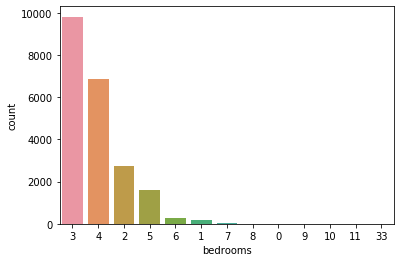

In [8]:
sns.countplot(df.bedrooms, order = df['bedrooms'].value_counts().index)

### View is an index from 0 to 4 of how good the view the property has

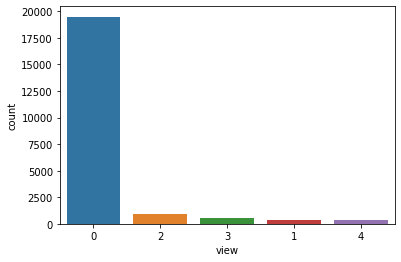

In [9]:
sns.countplot(df.view, order = df['view'].value_counts().index)

### Waterfront is a variable that's assigned 1 if the property overlooks a waterfront, 0 if it does not.

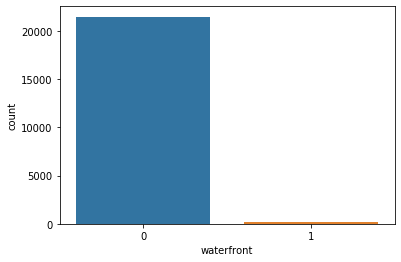

In [10]:
sns.countplot(df.waterfront, order = df['waterfront'].value_counts().index)

### Grade is an index from 1-13 that measures the structural quality and design of a house. 1 to 3 is poor construction and design, 7 is average, and 11 to 13 is high quality construction and design.

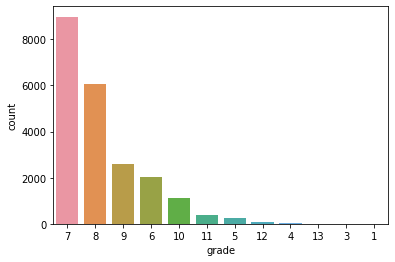

In [11]:
sns.countplot(df.grade, order = df['grade'].value_counts().index)

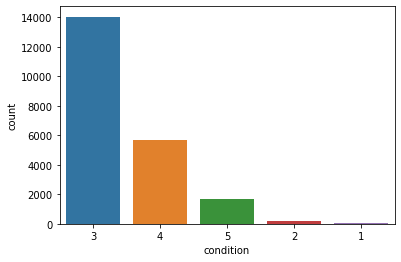

In [12]:
sns.countplot(df.condition, order = df['condition'].value_counts().index)

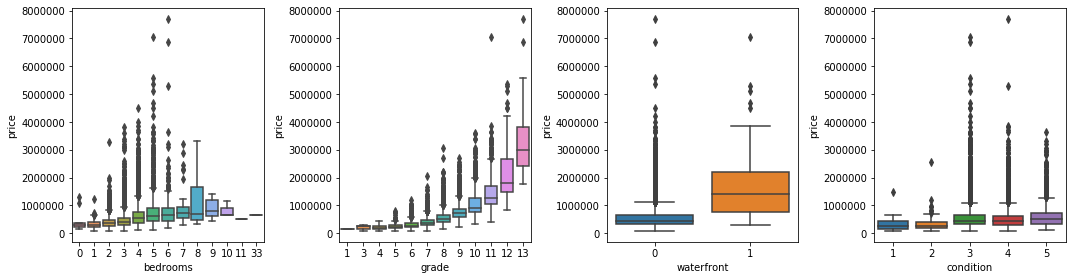

In [13]:
fig, axs = plt.subplots(1,4,figsize=(15,4))
sns.boxplot(x=df['bedrooms'],y = df['price'], ax = axs[0])
sns.boxplot(x=df['grade'],y = df['price'], ax = axs[1])
sns.boxplot(x = df['waterfront'],y = df['price'], ax = axs[2]); # 1 = overlooking a waterfront, 0 = not
sns.boxplot(x=df['condition'],y = df['price'], ax = axs[3])  # an index from 1 to 5 on the condition of the property

plt.tight_layout()

## Finding the largest correlation coefficients using a Correlation Matrix
### By using a correlation heatmap/matrix, we can visualize which variables have the highest/lowest correlation coefficient with price. 

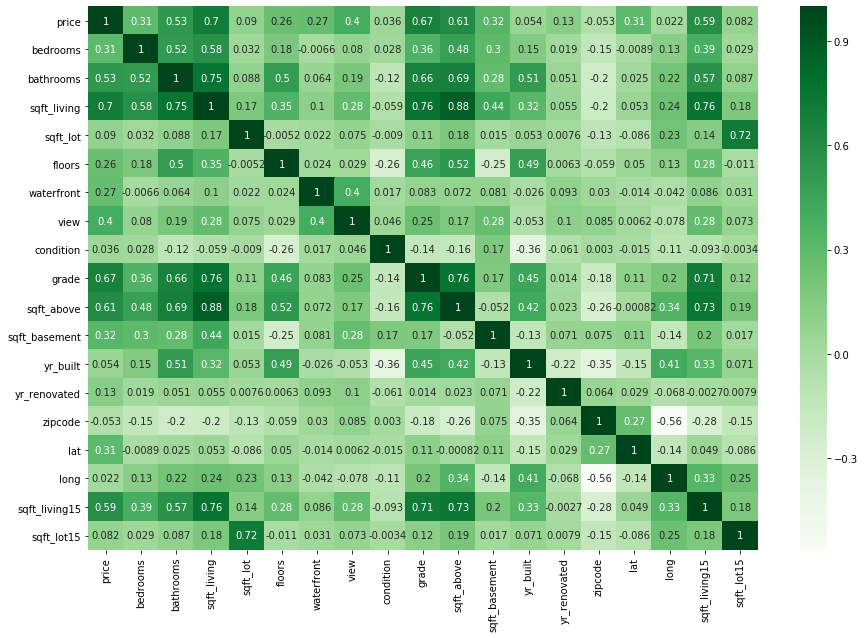

In [14]:
fig, ax = plt.subplots(figsize = (15, 10))
mat = sns.heatmap(df.corr(), annot=True, cmap="Greens")
plt.show()


### Based on the results from the correlation heatmap, we can see that price and living area sqft (sqft_living) have the heighest correlation coefficient at 0.7.
* The top five heighest correlation coefficients are:
    * sqft_living (0.7) -  Living area sqft.
    * grade (0.67) - Level of construction quality and design.
    * sqft_above (0.61) - Above ground sqft.
    * sqft_living15 (0.59) - The interior sqft of the 15 nearest neighbors houses.
    * bathrooms (0.53) - The number of bathrooms in the property.

#### Now let's analyzie the relationships between these variables and price

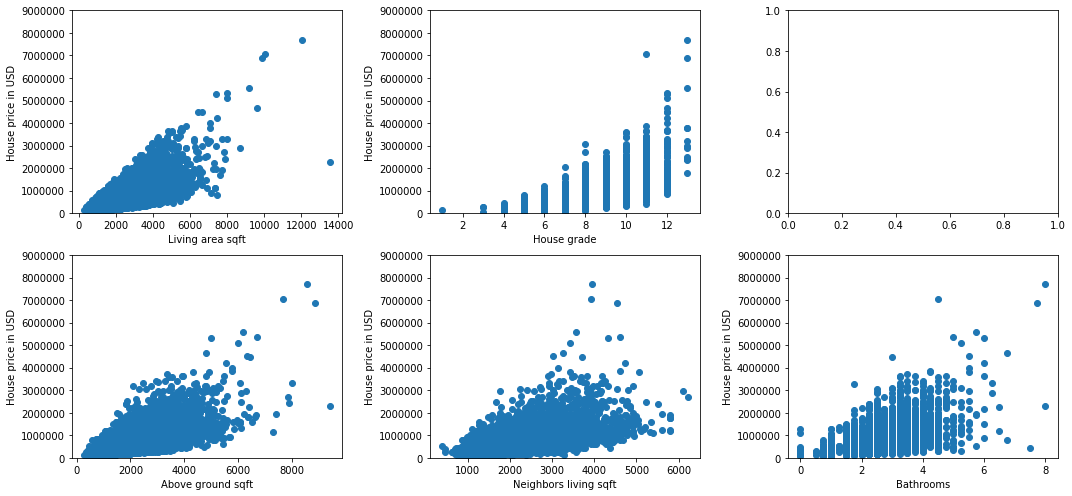

In [15]:
fig ,axs = plt.subplots(2,3 ,figsize=(15,7))

axs[0,0].scatter(x = df["sqft_living"], y = df["price"])
axs[0,0].set(xlabel="Living area sqft", ylabel="House price in USD", ylim=(0,9000000))

axs[0,1].scatter(x = df["grade"], y = df["price"])
axs[0,1].set(xlabel="House grade", ylabel="House price in USD", ylim=(0,9000000))


axs[1,0].scatter(x = df["sqft_above"], y = df["price"])
axs[1,0].set(xlabel="Above ground sqft", ylabel="House price in USD", ylim=(0,9000000))


axs[1,1].scatter(x = df["sqft_living15"], y = df["price"])
axs[1,1].set(xlabel="Neighbors living sqft", ylabel="House price in USD", ylim=(0,9000000))


axs[1,2].scatter(x= df['bathrooms'], y= df['price'])
axs[1,2].set(xlabel="Bathrooms", ylabel="House price in USD", ylim=(0,9000000))


#axs[0,2].scatter(x= df['zipcode'], y= df['price'])
#axs[0,2].set(xlabel="Condition", ylabel="House price in USD", ylim=(0,9000000))

plt.tight_layout()

Text(27.125, 0.5, 'Property price')

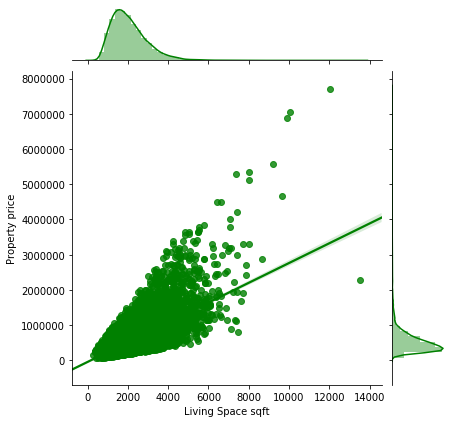

In [16]:
sns.jointplot(data=df, x='sqft_living', y='price', kind='reg', color='g')

plt.xlabel('Living Space sqft')
plt.ylabel('Property price')

## The prediction methods I wil be using are Multiple Linear Regression, and Random Forest Regression

### Spliting the training size to 70% and test to 30%

In [17]:

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix

In [18]:
train_df, test_df = train_test_split(df, test_size=0.3)

In [19]:
# Mutlitple Linear Regression
# Using the 5 features with the strongest coorelation found from 

mlr = linear_model.LinearRegression()
x = np.asanyarray(train_df[['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']])

y = np.asanyarray(train_df[['price']])
mlr.fit(x, y)
print ('Coefficients: ', mlr.coef_)


Coefficients:  [[ 2.43972184e+02  1.11370361e+05 -8.25881509e+01  2.79487658e+01
  -3.48508172e+04]]


In [20]:
# Prediction and model evaluation
y_hat = mlr.predict(test_df[['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 
                              'bathrooms']])

x = np.asanyarray(test_df[['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']])

y = np.asanyarray(test_df[['price']])
print("Residual sum of squares: %.2f" % np.mean((y_hat - y) ** 2))

print('Variance score: %.3f' % (mlr.score(x, y)))


Residual sum of squares: 65460591514.27
Variance score: 0.535


### We only have 55%  accuracy using the most important features from the coorelation matrix.

### Let's try MLR again, using all features

In [21]:
# Using all features with MLR
X = df.iloc[:,1:].values    # Features
y = df.iloc[:,0].values     # price


In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [23]:
mlr = LinearRegression()
mlr.fit(X_train,y_train)
mlr_score = mlr.score(X_test,y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(pred_mlr,y_test)


In [24]:
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))

Multiple Linear Regression Model Score is  69.0


### Using all features, we got better prediciton accuracy at 69%.



## Random Forest Regression

In [25]:
X_train, X_test, y_train,y_test = train_test_split (X,y,test_size=0.3,random_state=3)

In [26]:
rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)
rf_pred =rf.predict(X_test)
rf_score=rf.score(X_test,y_test)
rf_var = explained_variance_score(rf_pred,y_test)


In [27]:
print("Random Forest Regression Model Score is ",round(rf.score(X_test,y_test)*100))

Random Forest Regression Model Score is  88.0


## Feature Ranking 

In [28]:
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler

In [29]:
Y = df.price.values
# Drop price from the house dataframe and create a matrix out of the house data
house = df.drop(['price'], axis=1)
X = house.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = house.columns

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [30]:
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [31]:
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [32]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.7s finished


In [33]:
feat_rank = {}
for name in colnames:
    feat_rank[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = feat_rank
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	RF	RFE	Mean
bedrooms	0.0	0.59	0.3
bathrooms	0.01	0.71	0.36
sqft_living	0.87	0.35	0.61
sqft_lot	0.04	0.0	0.02
floors	0.0	0.47	0.24
waterfront	0.09	1.0	0.55
view	0.03	0.76	0.4
condition	0.0	0.65	0.32
grade	1.0	0.88	0.94
sqft_above	0.07	0.29	0.18
sqft_basement	0.01	0.24	0.12
yr_built	0.08	0.53	0.3
yr_renovated	0.0	0.12	0.06
zipcode	0.04	0.41	0.22
lat	0.51	0.94	0.72
long	0.22	0.82	0.52
sqft_living15	0.09	0.18	0.14
sqft_lot15	0.04	0.06	0.05


In [34]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(feat_rank.items()), columns= ['Feature','Mean Ranking'])

meanplot = meanplot.sort_values('Mean Ranking', ascending=False)


//anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

//anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



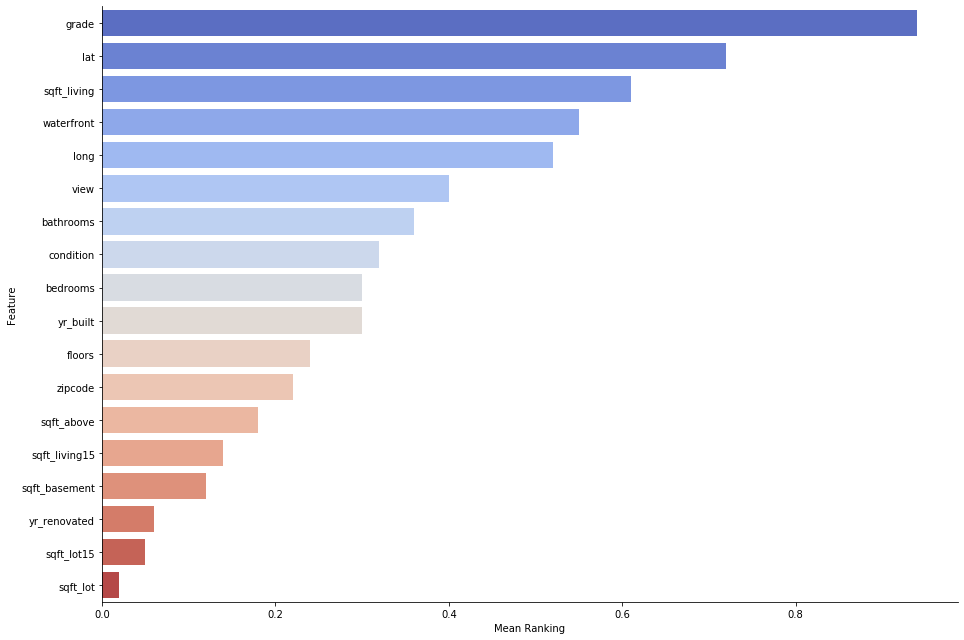

In [35]:
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=9, aspect=1.5, palette='coolwarm')


In [36]:
#!pip install chart_studio
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [37]:

df["color"] = ""
df.color[df.grade == 1] = "rgb(255,255,255)"
df.color[df.grade == 2] = "rgb(220,220,220)"
df.color[df.grade == 3] = "rgb(242, 177, 172)"
df.color[df.grade == 4] = "rgb(255,133,27)"
df.color[df.grade == 5] = "rgb(255,255,204)"
df.color[df.grade == 6] = "rgb(255,65,54)"
df.color[df.grade == 7] = "rgb(178,37,188)"
df.color[df.grade == 8] = "rgb(51,51,0)"
df.color[df.grade == 9] = "rgb(37,188,127)"
df.color[df.grade == 10] = "rgb(26,51,176)"
df.color[df.grade == 11] = "rgb(132,10,10)"
df.color[df.grade == 12] = "rgb(82,80,80)"
df.color[df.grade == 13] = "rgb(0,0,0)"

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying 

In [38]:
dataplus = df[np.logical_and(df.grade >= 7,df.yr_built >= 2000)] 
#list lat and long
lats = list(dataplus.lat.values)
longs = list(dataplus.long.values)

In [39]:
mapbox_access_token = 'pk.eyJ1IjoiZGFya2NvcmUiLCJhIjoiY2pscGFheHA1MXdqdjNwbmR3c290MTZ6dCJ9.K1FMv_q3ZVlKP13RrjFkjg'

mapp = [go.Scattermapbox(lat=lats,lon=longs,mode="markers",marker=dict(size=4.5,color=dataplus["color"]) ,hoverinfo="text",text="Grade:"+dataplus.grade.apply(str)+" Built Year:"+dataplus.yr_built.apply(str)+" Price:"+dataplus.price.apply(str))]

layout5 = dict(title="Grade(+7) - Built Year(+2000) Map",width=800,height=750,hovermode="closest",mapbox=dict(bearing=0,pitch=0,zoom=9,center=dict(lat=47.5,lon=-122.161),accesstoken=mapbox_access_token))

fig5 = go.Figure(data=mapp,layout=layout5)

iplot(fig5)

# map code from https://www.kaggle.com/darkcore/house-sales-visualization

## Conclusion

### The Random Forest method was the best with 88% accuracy using the variance score, we have a fairly good prediction rate of finding house prices.
### I think the model could be better if I cleaned up the data by taking out some outliers.

### References

https://www.kaggle.com/harlfoxem/housesalesprediction

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html